# Librerias

In [3]:
#!pip install wandb

In [9]:
#!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
import xgboost as xgb
from xgboost import XGBClassifier
#from wandb.xgboost import wandb_callback
from sklearn.compose import ColumnTransformer
from xgboost import plot_importance
import lightgbm as lgb
import datetime

# Data

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:


In [169]:
df = pd.read_csv("dataset_SCL.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [170]:
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


# Helper Functions



In [172]:
class CFG:
    def __init__(self):
        self.target = 'target'
        self.seed = 1313
        self.test_size = 0.1
        self.Kfold = 5
cfg = CFG()

In [173]:
def display_metrics(y_test, y_preds, y_prob):
    """
    Función que reporta las métricas a considerar
    en este caso de uso
    """

    # Recall
    print("===== Recall Score =====")
    recall = recall_score(y_test, y_preds)
    print(f'Recall Test Score: {recall:.3f}')


    # F1 Score
    print("===== F1 Score =====")
    f1 = f1_score(y_test, y_preds)
    print(f'Test F1 Score: {f1:.3f}')

    # AUC Score
    print("===== AUC Score =====")
    auc = roc_auc_score(y_test, y_prob[:, 1])
    print(f'AUC Score: {auc:.3f}')

    # Confusion Matrix
    print("===== Confusion Matrix =====")  
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
    disp.plot()
    plt.show()

    return f1, auc, cm, recall

In [174]:
def log_wandb(run, recall, f1, auc, test_preds, test_probs, model, X_train, y_train, X_test, y_test):
    
    """ Log métricas y gráficos en WandB"""

    # Metrics 
    run.summary["F1"] = f1
    run.summary["RECALL"] = recall
    run.summary["AUC"] = auc

    # Plots
    labels = ["no", "yes"]
    
    

    # ROC
    wandb.sklearn.plot_roc(y_test, test_probs, labels)

    # Confusion Matrix
    wandb.sklearn.plot_confusion_matrix(y_test, test_preds, labels)

    # Metrics
    wandb.sklearn.plot_summary_metrics(model, X_train, y_train, X_test, y_test)

In [175]:
import warnings

from sklearn.pipeline import Pipeline

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    
    # Get columns and bin edges
    def pair_bin_edges_columns(bins_edges, columns):
        all_edge_column = []
        for index in range(len(columns)):
            bin_edge = bins_edges[index]
            column = columns[index]
            
            pair_bin_edge = []
            # match consecutive bin edges together
            for first, second in zip(bin_edge, bin_edge[1:]):
                pair_bin_edge.append((first, second))
            
            bin_edge_column = [column +": ["+ str(edge[0]) +", "+ str(edge[1])+")"  for edge in pair_bin_edge]
            all_edge_column.extend(bin_edge_column)
        return all_edge_column
    
    
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            
            # For transformers that create bins
            if hasattr(trans, 'bin_edges_'):
                bins_edges = trans.bin_edges_
                pairs_edges_columns = pair_bin_edges_columns(bins_edges, column)
            if column is None:
                return []
            else:
                return [name + "__" + f for f in pairs_edges_columns]
        return [name + "__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Parte 1. EDA

¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

Primero utilizaré una herramienta rápida de profiling. Podemos hacerlo porque la data no es muy grande y no entramos en problemas de RAM al utilizarla. En caso de tener data más grande, deberiamos utilizar otras herramientas como pyspark, pandas o polars.

In [8]:
#!pip install ydata_profiling

In [18]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Insights

- Ausencia de variables numéricas: La mayoría (si no todas, son variables categóricas)
- Existen variables con valores únicos (los eliminaré). Podrian usarse para extraer información externa, pero ese no será el caso.
- Muchas de las variables categóricas tienen alta dimension, esto podría afectar a los modelos (Curse of Dimensionality). Es por esto que tendré que tomar medidas con respecto a esto (hash, pca, target encoding, etc.)
- Por la misma razón (variables categóricas), es que creo que un modelo basado en árboles se ajustará mejor, es por esto que comenzaré por ahi.
- Si bien tenemos info de fecha, no es un problema secuencial (de series de tiempo), por lo que la estrategia de validación puede ser simple.

In [176]:
# Eliminar Variables Únicas
df.drop(labels = ["Ori-I", "Ori-O", "AÑO", "SIGLAORI"], axis = 1, inplace = True)

In [177]:
# Analizar el balance entre variables categóricas y el target
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols

['Fecha-I',
 'Vlo-I',
 'Des-I',
 'Emp-I',
 'Fecha-O',
 'Vlo-O',
 'Des-O',
 'Emp-O',
 'DIANOM',
 'TIPOVUELO',
 'OPERA',
 'SIGLADES']

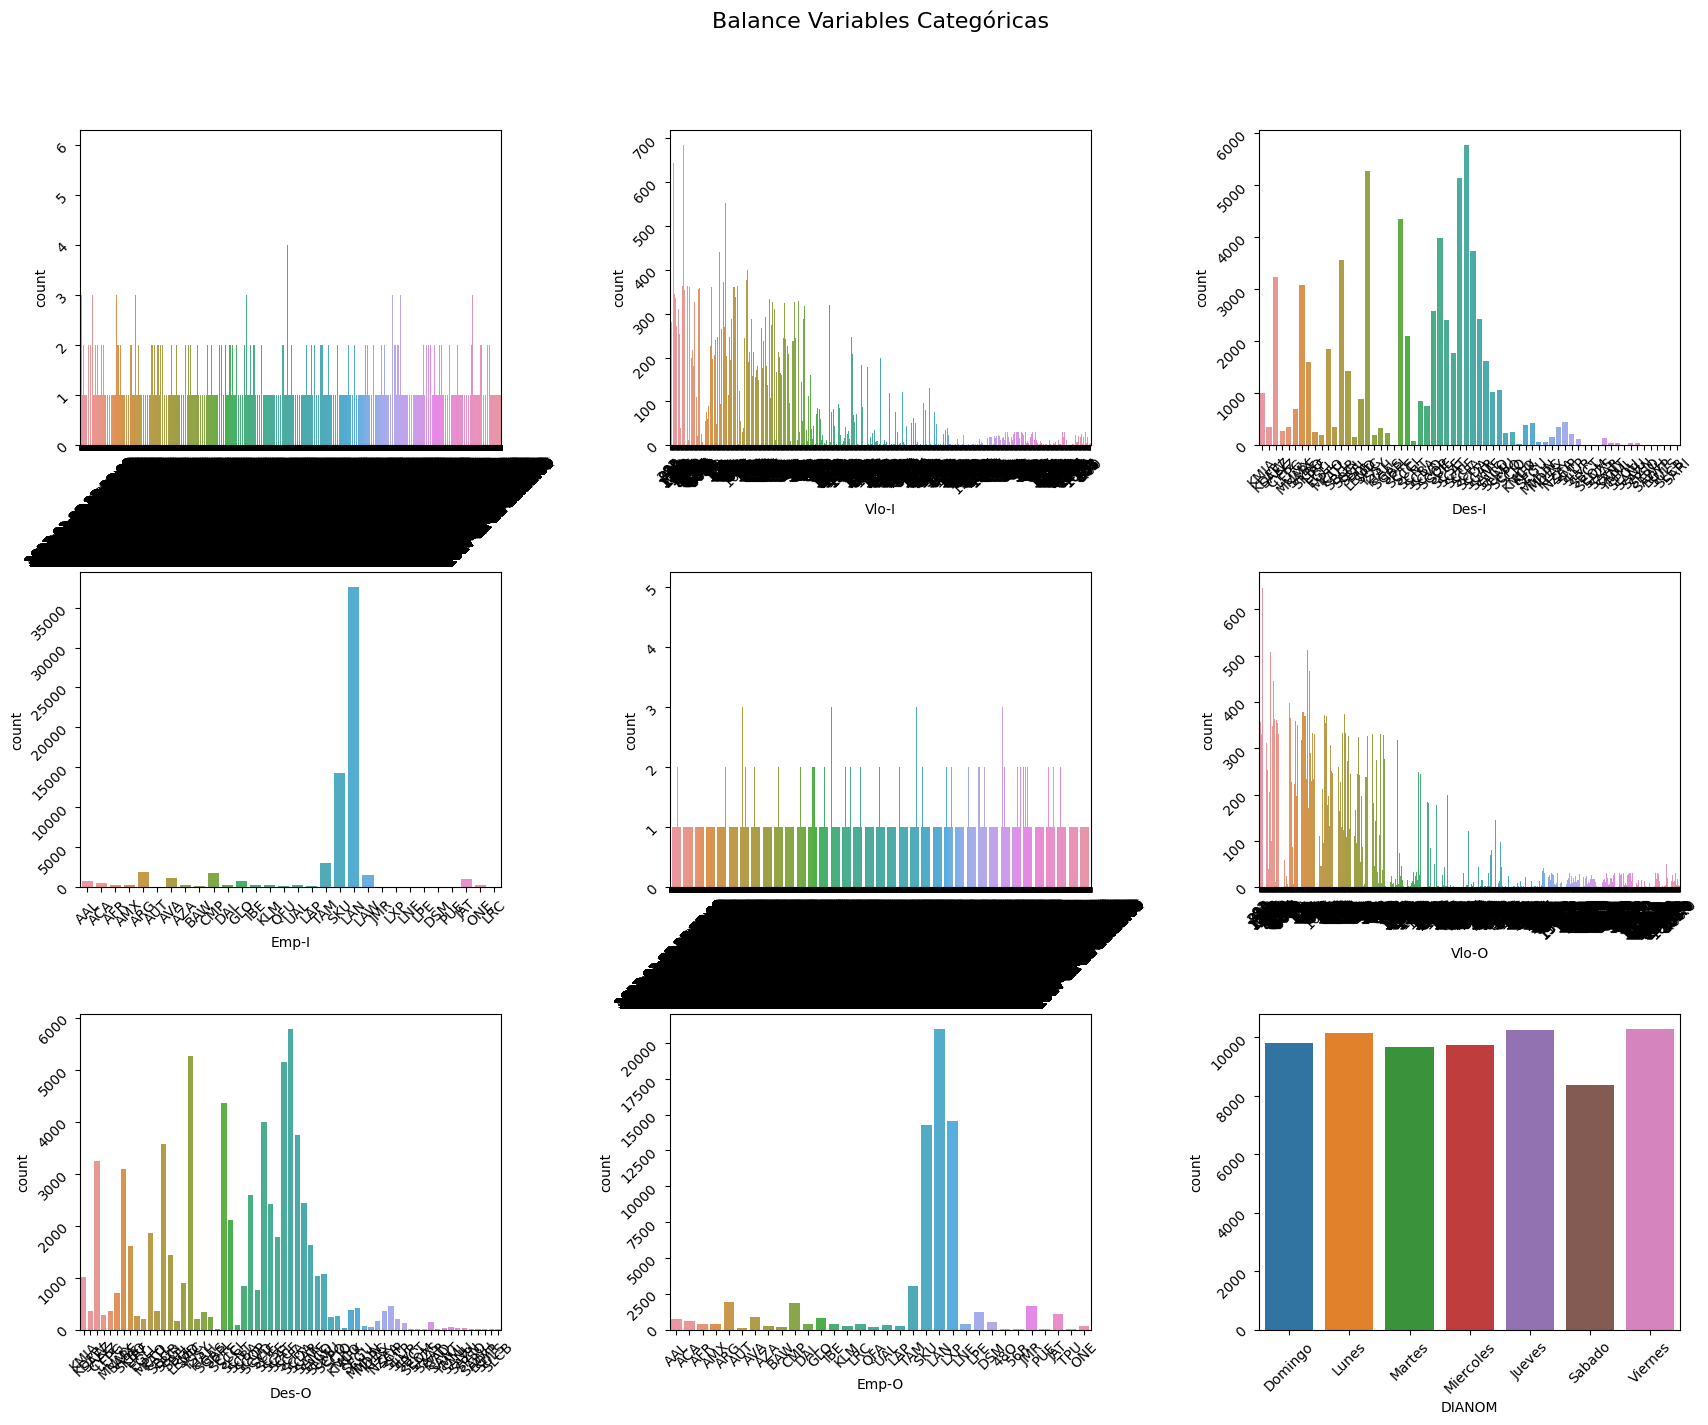

In [178]:
# Balanceo variables categóricas
fig, axs = plt.subplots(3,3, figsize = (20,15))
fig.tight_layout()
i_col = 0
for i in range(3):
  for j in range(3):
    sns.countplot(data=df, x = cat_cols[i_col], ax=axs[i,j])
    axs[i,j].tick_params(labelrotation=45);
    i_col+=1

plt.subplots_adjust(left=0.1,
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  wspace=0.4,
                  hspace=0.4)
fig.suptitle("Balance Variables Categóricas", fontsize=16);
plt.show()

TODO: FIX THIS (es mas complejo ver las variables que tiene dimensionalidad muy alta)

# Parte 2. Preprocessing
Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv 

In [14]:
df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,Lima
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,Lima
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,Lima
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,Lima


In [15]:
print(f"La información va desde {df['Fecha-I'].min()} hasta {df['Fecha-I'].max()}")

La información va desde 2017-01-01 00:15:00 hasta 2017-12-31 23:55:00


In [16]:
# a. temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
# Hay sólo aun año asi que podemos aprovechar esto

df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])

mask_1 = df["Fecha-I"].between(datetime.datetime(2016,12,15), datetime.datetime(2017,3,3))
mask_2 = df["Fecha-I"].between(datetime.datetime(2017,7,15), datetime.datetime(2017,7,31))
mask_3 = df["Fecha-I"].between(datetime.datetime(2017,9,11),  datetime.datetime(2017,9,30))

df["TAlta"] = 0
df.loc[(mask_1 | mask_2 | mask_3), "TAlta"] = 1

In [17]:
# Sanity Check
df[df["TAlta"]==1]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,TAlta
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49731,2017-09-29 17:37:00,253,SCTE,JAT,2017-09-29 18:02:00,253,SCTE,JAT,29,9,Viernes,N,JetSmart SPA,Puerto Montt,1
49732,2017-09-25 13:21:00,281,SCQP,JAT,2017-09-25 13:18:00,281,SCQP,JAT,25,9,Lunes,N,JetSmart SPA,Temuco,1
49733,2017-09-26 13:21:00,281,SCQP,JAT,2017-09-26 13:12:00,281,SCQP,JAT,26,9,Martes,N,JetSmart SPA,Temuco,1
49734,2017-09-27 13:00:00,281,SCQP,JAT,2017-09-27 13:02:00,281,SCQP,JAT,27,9,Miercoles,N,JetSmart SPA,Temuco,1


In [18]:
# b. dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"])
df["Fecha-O"] = pd.to_datetime(df["Fecha-O"])
df["dif_min"] = (df["Fecha-O"] - df["Fecha-I"]).dt.total_seconds()/60


In [19]:
df["dif_min"]

0         3.0
1         9.0
2         9.0
3         3.0
4        -2.0
         ... 
68201    46.0
68202    16.0
68203    40.0
68204    13.0
68205     9.0
Name: dif_min, Length: 68206, dtype: float64

In [20]:
# c. target atraso_15: 1 si dif_min > 15, 0 si no
df["target"] =  np.where(df['dif_min']>15, 1, 0)

In [21]:
# d. periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I.
df.set_index(df["Fecha-I"], inplace = True)
# Creamos columna
df['periodo_dia'] = np.nan

# Label
df.loc[df.between_time('05:00', '11:00').index, "periodo_dia"] = "mañana"
df.loc[df.between_time('12:00', '18:59').index, "periodo_dia"] = "tarde"
df.loc[df.between_time('19:00', '04:59').index, "periodo_dia"] = "noche"

# Volvemos el indice
df.reset_index(drop = True, inplace = True)

In [22]:
df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,TAlta,dif_min,target,periodo_dia
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1,-2.0,0,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,Lima,0,46.0,1,tarde
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,Lima,0,16.0,1,tarde
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,Lima,0,40.0,1,tarde
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,Lima,0,13.0,0,tarde


In [23]:
#df.to_csv('synthetic_features.csv', index = False)

In [51]:
df = pd.read_csv('synthetic_features.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Parte3. Target EDA 
¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?

In [52]:
df.MES.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [25]:
obs_cols = ["Des-I", "OPERA", "MES", "DIANOM", "TAlta", "TIPOVUELO"]

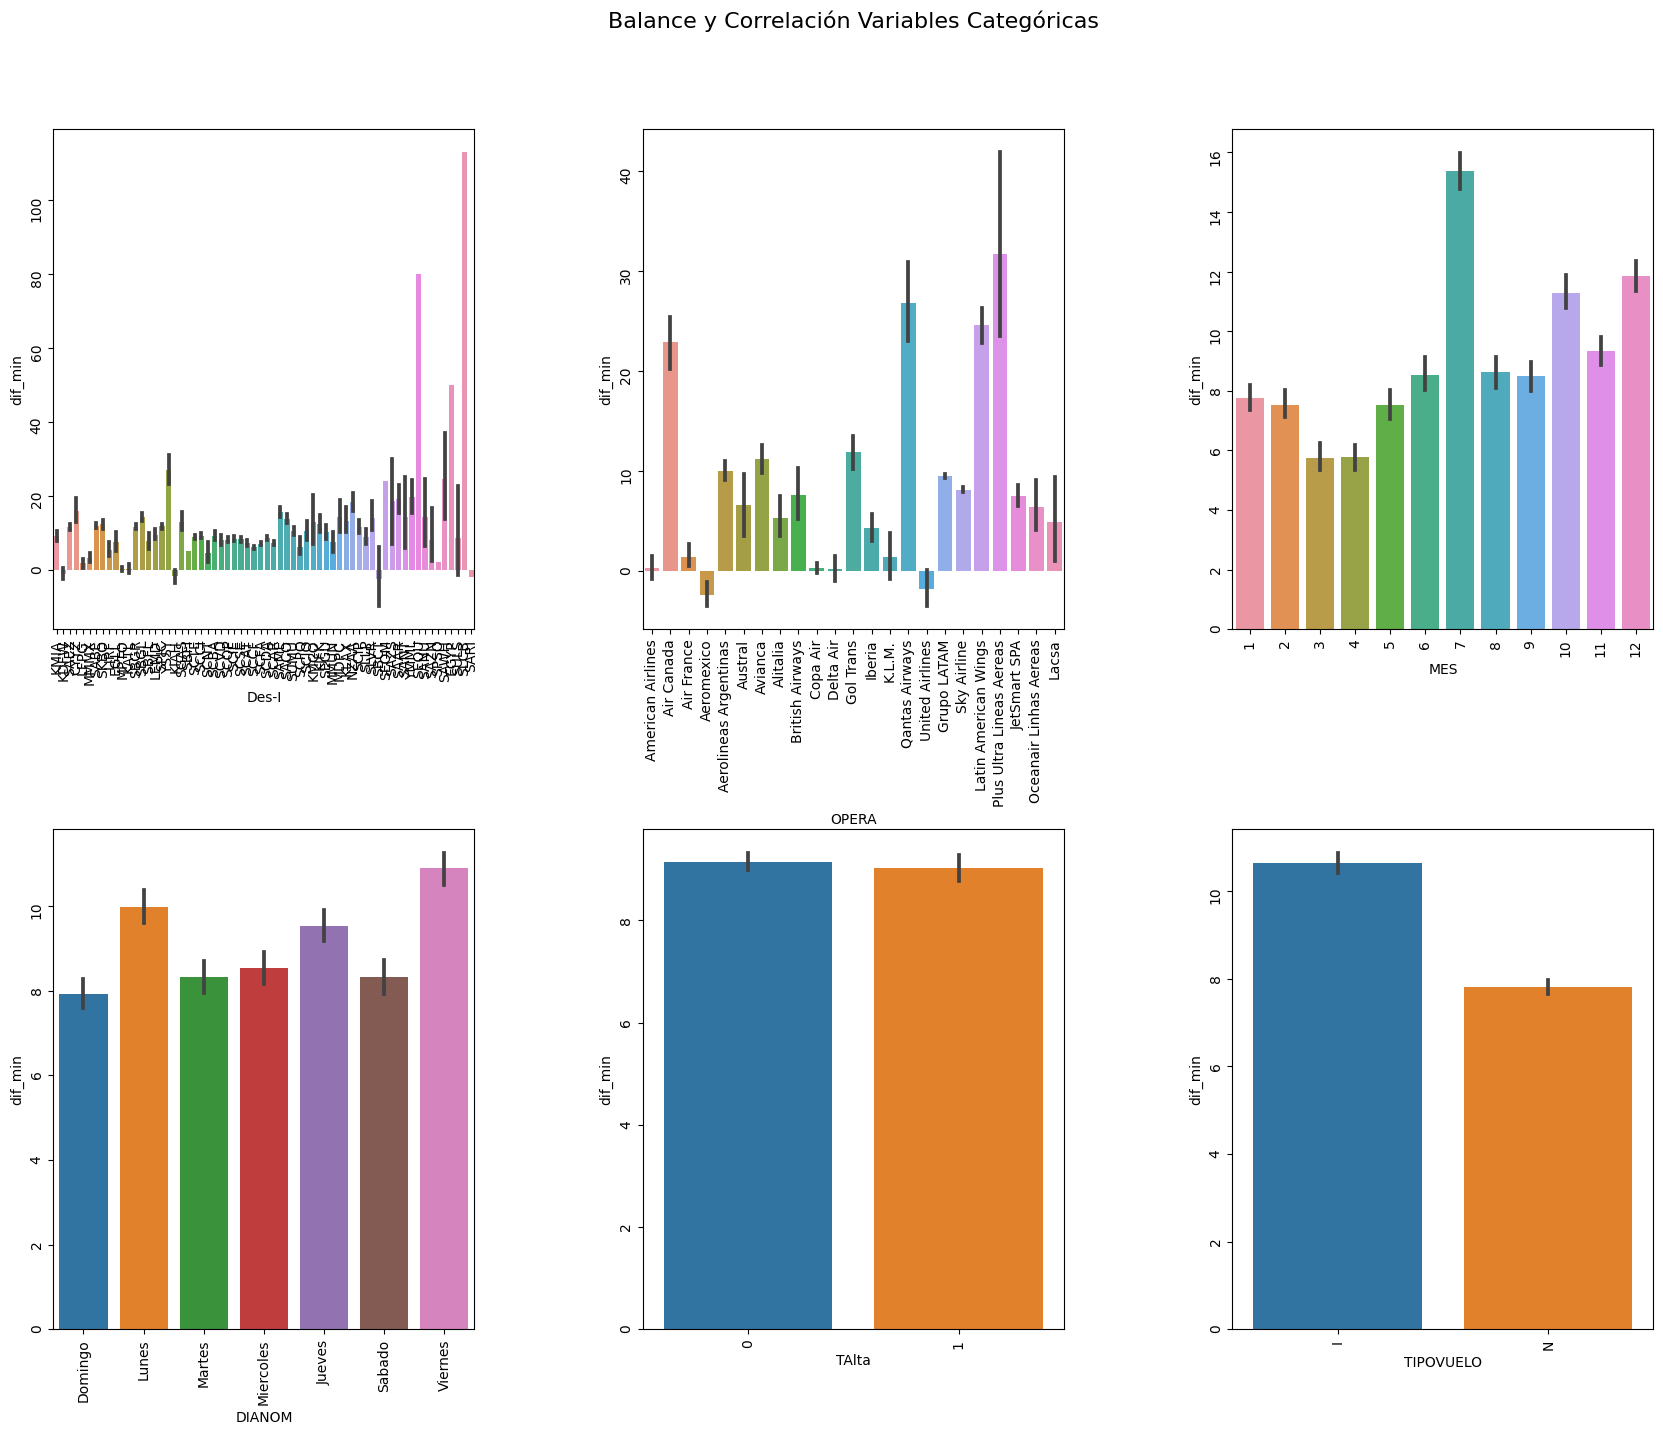

In [26]:
# Balanceo y Correlación con target
fig, axs = plt.subplots(2,3, figsize = (20,15))
fig.tight_layout()
i_col = 0
for i in range(2):
  for j in range(3):
    sns.barplot(data=df, y = "dif_min", ax=axs[i,j], x = obs_cols[i_col])
    axs[i,j].tick_params(labelrotation=90);
    i_col+=1

plt.subplots_adjust(left=0.1,
                  bottom=0.1,
                  right=0.9,
                  top=0.9,
                  wspace=0.4,
                  hspace=0.4)
fig.suptitle("Balance y Correlación Variables Categóricas", fontsize=16)
plt.show();

In [ ]:
df.groupby('OPERA', as_index = False)['dif_min'].mean().sort_values(by='dif_min', ascending = False)

Pareciera que las variables que más afectan el tiempo de delay. Aquellas variables que más parecen tener patrones marcados y pueden ser importantes a la hora de entrenar son:

- Des-I : Vemos que existen algunos destinos con un promedio de tiempos de atraso bastante grandes, tales como: Cochabamba, Quito o Egipto
- Aerolinea: En cuanto a Aerolineas vemos que aquellas con más atraso promedio son: Plus Ultra Lineas Aereas, Qantas Airways y Latin American Wings
- Mes: Vemos que Julio tiene una alta cantidad de atrasos
- Tipo Vuelo: Los vuelos internacionales tienen tener mayores atrasos

<AxesSubplot:xlabel='target', ylabel='count'>

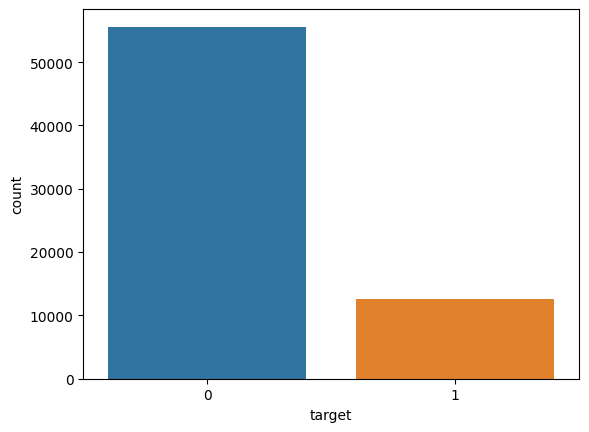

In [37]:
# Como se comporta el target
sns.countplot(data = df, x = 'target')

In [38]:
df.target.value_counts()

0    55592
1    12614
Name: target, dtype: int64

In [29]:
# DATA IMBALANCEADA!

# Parte 4 & 5. Prototyping

En la experimentación, utilizaremos la herramienta de experiment tracking `weight & bias`. No es estrictamente necesario dado que probablemente no probaré muchos modelos, pero sirve como demostración. El flujo de experimentación será algo como:

1. **Construir Baseline**: La idae es que sea un modelo simple y fácil de iterar. Ya que es un problema de *clasificación* y tenemos muchas variables categóricas, usaré `RandomForest`.
2. **Complejizar Modelo**: Acá la idea es ver si agregandole complejidad a la solución podemos capturar de mejor forma los patrones que envuelven al problema. Para esto utilizaré modelos basados en boosteo de Árboles de decisión (XGBoost, LightGBM). Porque? Porque suelen entregar buenos resultados y tienen un buen nivel de explicabilidad, claramente podemos probar un montón de otros modelos más. 
3. **Feature Engineering**: Como último paso intentaré mejorar el modelo actual creando nuevas features que ayuden al modelo a converger de más rápido.

4. 😓**Ensemble**: Ensamblar modelos puede ser un paso ideal, pero en esta ocasión lo omitiré, ya que creo que el objetivo de esto no es tener el mejor performance posible, si no evaluar la resolución de problemas en un contexto de Machine Learning. 

> 🛑 Importante! Antes debemos escoger un método de evaluación y métricas a considerar.

> 🐝  **W&B** se puede aprovechar para experiment tracking, model versioning, report colaboration, hyperparameter tunning, etc. En este caso sólo lo utilizaremos para experiment tracking

> 🛑 Alerta! Recordemos que estamos en un problema con clase imbalanceada. Existen numerosas técnicas para esto (Undersampling, Oversampling, Cost Functions, etc.). No soy muy fan de las primeras dos, por lo que alteraré la función de costos agregandole mayor peso a la clase menor.

## 🐝 W&B🐝 Login 

In [32]:
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

## Evaluación

In [33]:
df

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,TAlta,dif_min,target,periodo_dia
0,2017-01-01 23:30:00,226,KMIA,AAL,2017-01-01 23:33:00,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,KMIA,AAL,2017-01-02 23:39:00,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,KMIA,AAL,2017-01-03 23:39:00,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,KMIA,AAL,2017-01-04 23:33:00,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,KMIA,AAL,2017-01-05 23:28:00,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1,-2.0,0,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SPJC,JAT,2017-12-22 15:41:00,400.0,SPJC,JAT,22,12,Viernes,I,JetSmart SPA,Lima,0,46.0,1,tarde
68202,2017-12-25 14:55:00,400,SPJC,JAT,2017-12-25 15:11:00,400.0,SPJC,JAT,25,12,Lunes,I,JetSmart SPA,Lima,0,16.0,1,tarde
68203,2017-12-27 14:55:00,400,SPJC,JAT,2017-12-27 15:35:00,400.0,SPJC,JAT,27,12,Miercoles,I,JetSmart SPA,Lima,0,40.0,1,tarde
68204,2017-12-29 14:55:00,400,SPJC,JAT,2017-12-29 15:08:00,400.0,SPJC,JAT,29,12,Viernes,I,JetSmart SPA,Lima,0,13.0,0,tarde


In [53]:
# Elimino fechas e información de operación ya que no estará disponible al momento de la inferencia##
df.drop(labels = ['Fecha-I', 'Fecha-O', 'Vlo-O', 'Des-O', 'Emp-O'], axis = 1, inplace = True) # Para FEATURE ENGINEERING
#df.drop(labels = ['Fecha-I', 'Fecha-O', 'dif_min', 'Vlo-O', 'Des-O', 'Emp-O'], axis = 1, inplace = True)

In [54]:
# Features categóricas y numéricas
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'target']
num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'target']

### Metric

Nos encontramos con un problema de `clasificación`. La métrica más común es **Accuracy**, pero debido a que nos encontramos con un target imbalanceado, ésta no es adecuada.


Algo importante en estos tipos de problemas, es identificar que es más costoso, falsos negativos o positivos?
Para esto necesitamos saber que decisión podemos tomar con las predicciones a obtener. En este caso creo que la respuesta no es tan directa, de que sirve saber desde antes si un vuelo llegará atrasado? avisar a los pasajeros? si les avisamos, que diferencia habria?. Por último, cuanto antes predeciremos? Al parecer según los datos podriamos predecir desde cuando tenemos info tal como el destino, aerolinea, etc. de un vuelo, por lo que podria ser incluso con meses de anticipación.

En este caso supondré que las medidas a tomar en caso de reconocer un vuelo con atraso probable serán ocupar recursos para evitar el atraso (pensemos en recursos como costos). Según esto, en el caso de un **falso positivo** (el modelo predice atraso pero en realidad no hubo) habremos gastado recursos en vano, recursos que pudieron haberse utilizado en otras cosas. En cambio, en el caso de un **falso negativo** (el modelo predijo que no habría atraso pero si hubo), podria generar la molestia de los pasajeros, perdidas de vuelos (escalas), reclamos por compensaciones y pérdida en fidelidad de los clientes.

En base a lo anterior, creo que son más costosos los falsos negativos, por lo que una métrica a considerar relevante sería **recall** 

Aún así pondré además atención en **F1 Score, AUC** y observaré la **matriz de confusión.**

### Test Split

In [ ]:
# Paso 1: Fijar un conjunto de testeo (o hold-out)

# Features & Target
y = df.pop(cfg.target)
X = df.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=cfg.test_size, random_state=cfg.seed, stratify = y)

# To DataFrame
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)





In [80]:
# Se debe mantener el imbalanceo
y_test.value_counts(normalize = True)

0    0.81513
1    0.18487
Name: target, dtype: float64

# Baseline: RandomForest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:

# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=cfg.seed)

# Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", rf)]
)
# RandomSearch Grid
tf_param_grid = {
    "model__max_depth": [10, 50, 100, 200],
    "model__n_estimators": [50, 100, 200],
    #"model__min_weight_fraction_leaf" : np.logspace(-4, 4, 10)

}

In [40]:
for col in X_train.columns:
    if col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    if col in num_cols:
    X_train[col] = X_train[col].astype('int32')

In [41]:
r_search = RandomizedSearchCV(pipe, tf_param_grid, n_jobs=-1, verbose = 3, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__max_depth=100, model__n_estimators=100;, score=0.267 total time= 2.4min
[CV 5/5] END model__max_depth=100, model__n_estimators=100;, score=0.256 total time= 2.4min
[CV 4/5] END model__max_depth=50, model__n_estimators=200;, score=0.297 total time= 4.0min
[CV 5/5] END model__max_depth=200, model__n_estimators=50;, score=0.259 total time= 1.2min
[CV 3/5] END model__max_depth=100, model__n_estimators=200;, score=0.270 total time= 4.8min
[CV 2/5] END model__max_depth=50, model__n_estimators=100;, score=0.290 total time= 1.9min
[CV 5/5] END model__max_depth=50, model__n_estimators=100;, score=0.276 total time= 2.0min
[CV 4/5] END model__max_depth=200, model__n_estimators=100;, score=0.283 total time= 2.3min
[CV 2/5] END model__max_depth=100, model__n_estimators=50;, score=0.274 total time= 1.3min
[CV 1/5] END model__max_depth=10, model__n_estimators=100;, score=0.380 total time=   4.3s
[CV 3/5] END model__max_d

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['DIA',
                                                                                'MES',
                                                                                'TAlta']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Vlo-I',
                            

In [42]:
print("Best parameter (CV score=%0.3f):" % r_search.best_score_)
print(r_search.best_params_)

Best parameter (CV score=0.376):
{'model__n_estimators': 100, 'model__max_depth': 10}


In [43]:
test_preds = r_search.predict(X_test)
test_probs = r_search.predict_proba(X_test)
model = r_search.best_estimator_

===== Recall Score =====
Recall Test Score: 0.558
===== F1 Score =====
Test F1 Score: 0.354
===== AUC Score =====
AUC Score: 0.659
===== Confusion Matrix =====


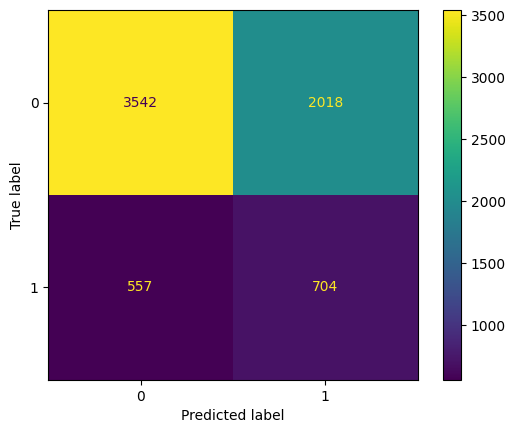

In [44]:
f1, auc, cm, recall = display_metrics(y_test, test_preds, test_probs)

In [45]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


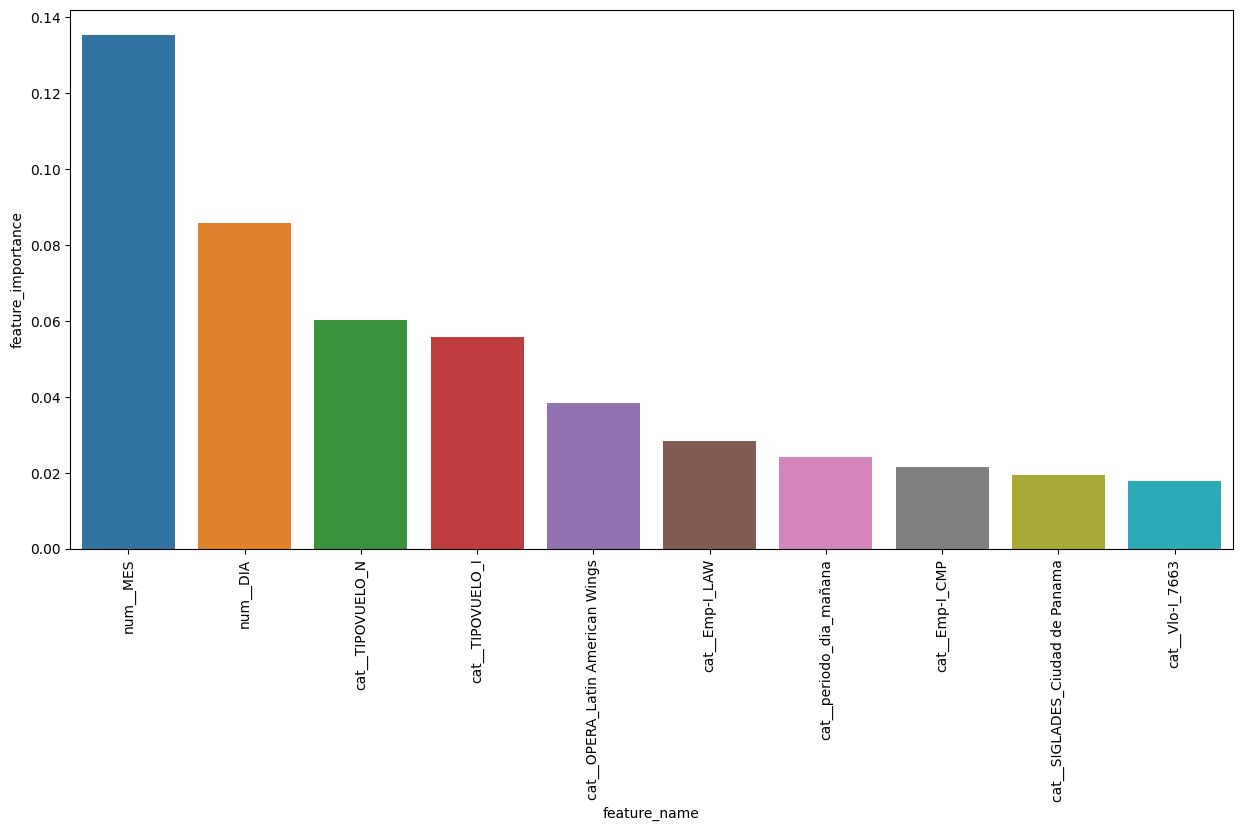

In [46]:
fig = plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [47]:
# WandB Logs
name = "baseline:v1"
tags = ["RandomForest", "ClassWeights"]

# Init run
run = wandb.init(project="LatamChallenge", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, recall, auc, test_preds, test_probs, model, X_train, y_train, X_test, y_test)
#run.log({"feature_importance": fig})
# Finish Run
run.finish()

wandb: Currently logged in as: diegulio. Use `wandb login --relogin` to force relogin


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: WARNING X_test contains 301 missing values. 
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.


AUC,0.65928
F1,0.55829
RECALL,0.3535


[CV 3/5] END model__max_depth=100, model__n_estimators=100;, score=0.267 total time= 2.4min
[CV 1/5] END model__max_depth=10, model__n_estimators=200;, score=0.382 total time=   8.8s
[CV 4/5] END model__max_depth=10, model__n_estimators=200;, score=0.367 total time=   8.7s
[CV 2/5] END model__max_depth=50, model__n_estimators=200;, score=0.290 total time= 4.0min
[CV 1/5] END model__max_depth=200, model__n_estimators=50;, score=0.257 total time= 1.2min
[CV 3/5] END model__max_depth=200, model__n_estimators=50;, score=0.261 total time= 1.2min
[CV 1/5] END model__max_depth=100, model__n_estimators=200;, score=0.265 total time= 4.8min
[CV 5/5] END model__max_depth=100, model__n_estimators=200;, score=0.265 total time= 4.9min
[CV 3/5] END model__max_depth=200, model__n_estimators=100;, score=0.264 total time= 2.4min
[CV 3/5] END model__max_depth=100, model__n_estimators=50;, score=0.260 total time= 1.3min
[CV 2/5] END model__max_depth=10, model__n_estimators=100;, score=0.380 total time=   

# Baseline + FE : RandomForest + FE
Ahora probaremos con un poco de FE. Reemplazaremos aquellas variables categóricas con dimensionalidades altas con un embedding de sus estadisticas en base al target (mean, min,max, std). Por temas de tiemp no se agregaron más, ni tampoco variables externar. A modo de idea, algunas variables que considero relevantes:

- Info del Clima: El clima afecta directamente a las Aerolineas, esto podria ser vital a la hora de predecir retrasos
- Cantidad de pasajeros en el vuelo
- Horas de vuelo (Probablemente trayectos más largos se atrasen más)
- Info de las Aerolineas

In [131]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [58]:
# Columnas a hacer embeddings
encoded_cols = ['Vlo-I', 'Des-I', 'Emp-I', 'SIGLADES']

In [59]:
# Target Encoder de algunas columnas con mucha dimensión
encoded_cats = {}
for cat_col in encoded_cols:
    temp = X_train.groupby(cat_col)['dif_min'].agg(['mean', 'max', 'min', 'std'])
    temp.columns = [f'{cat_col}_{col}' for col in temp.columns]
    encoded_cats[cat_col] = temp.reset_index()
    

In [60]:
# Join
for cat_col in encoded_cols:
    X_train = pd.merge(X_train, encoded_cats[cat_col], how='left', on = cat_col)

In [61]:
X_train.drop(labels = encoded_cols + ['dif_min'], axis = 1, inplace = True)

In [62]:
# Features categóricas y numéricas
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and col != 'target']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object' and col != 'target']

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [133]:

# Logistic Regression
rf = RandomForestClassifier(class_weight='balanced', random_state=cfg.seed)

# Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", rf)]
)
# RandomSearch Grid
tf_param_grid = {
    "model__max_depth": [10, 50, 100, 500],
    "model__n_estimators": [100, 200],
    #"model__min_weight_fraction_leaf" : np.logspace(-4, 4, 10),
    #"model__alpha" : np.logspace(-4, 1, 10),

}

In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61385 entries, 0 to 61384
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DIA            61385 non-null  int64  
 1   MES            61385 non-null  int64  
 2   DIANOM         61385 non-null  object 
 3   TIPOVUELO      61385 non-null  object 
 4   OPERA          61385 non-null  object 
 5   TAlta          61385 non-null  int64  
 6   periodo_dia    61385 non-null  object 
 7   Vlo-I_mean     61385 non-null  float64
 8   Vlo-I_max      61385 non-null  float64
 9   Vlo-I_min      61385 non-null  float64
 10  Vlo-I_std      61261 non-null  float64
 11  Des-I_mean     61385 non-null  float64
 12  Des-I_max      61385 non-null  float64
 13  Des-I_min      61385 non-null  float64
 14  Des-I_std      61378 non-null  float64
 15  Emp-I_mean     61385 non-null  float64
 16  Emp-I_max      61385 non-null  float64
 17  Emp-I_min      61385 non-null  float64
 18  Emp-I_

In [66]:
for col in X_train.columns:
  if col in cat_cols:
    X_train[col] = X_train[col].astype(str)
  #if col in num_cols:
  #  X_train[col] = X_train[col].astype('int32')

In [135]:
r_search = RandomizedSearchCV(pipe, tf_param_grid, n_jobs=2, verbose = 1, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
r_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['DIA',
                                                                                'MES',
                                                                                'TAlta',
                                                                                'Vlo-I_mean',
                                                                                'Vlo-I_max',
                                                                                'Vlo-I_min',
                                            

In [136]:
print("Best parameter (CV score=%0.3f):" % r_search.best_score_)
print(r_search.best_params_)

Best parameter (CV score=0.413):
{'model__n_estimators': 100, 'model__max_depth': 10}


In [69]:
# Merge de Encoded Features
for cat_col in encoded_cols:
    X_test = pd.merge(X_test, encoded_cats[cat_col], how='left', on = cat_col)

In [70]:
X_test.drop(labels = encoded_cols, axis = 1, inplace = True)

In [137]:
test_preds = r_search.predict(X_test)
test_probs = r_search.predict_proba(X_test)
model = r_search.best_estimator_

===== Recall Score =====
Recall Test Score: 0.559
===== F1 Score =====
Test F1 Score: 0.397
===== AUC Score =====
AUC Score: 0.694
===== Confusion Matrix =====


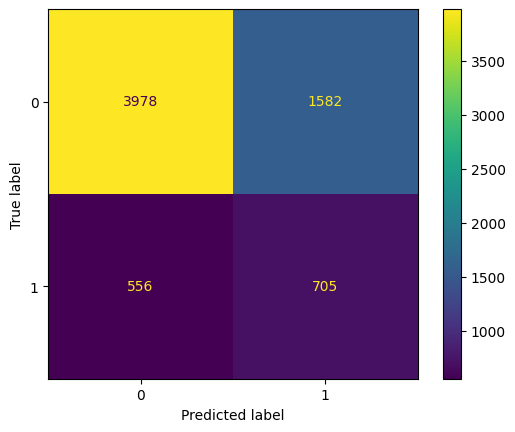

In [138]:
f1, auc, cm, recall = display_metrics(y_test, test_preds, test_probs)

In [73]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


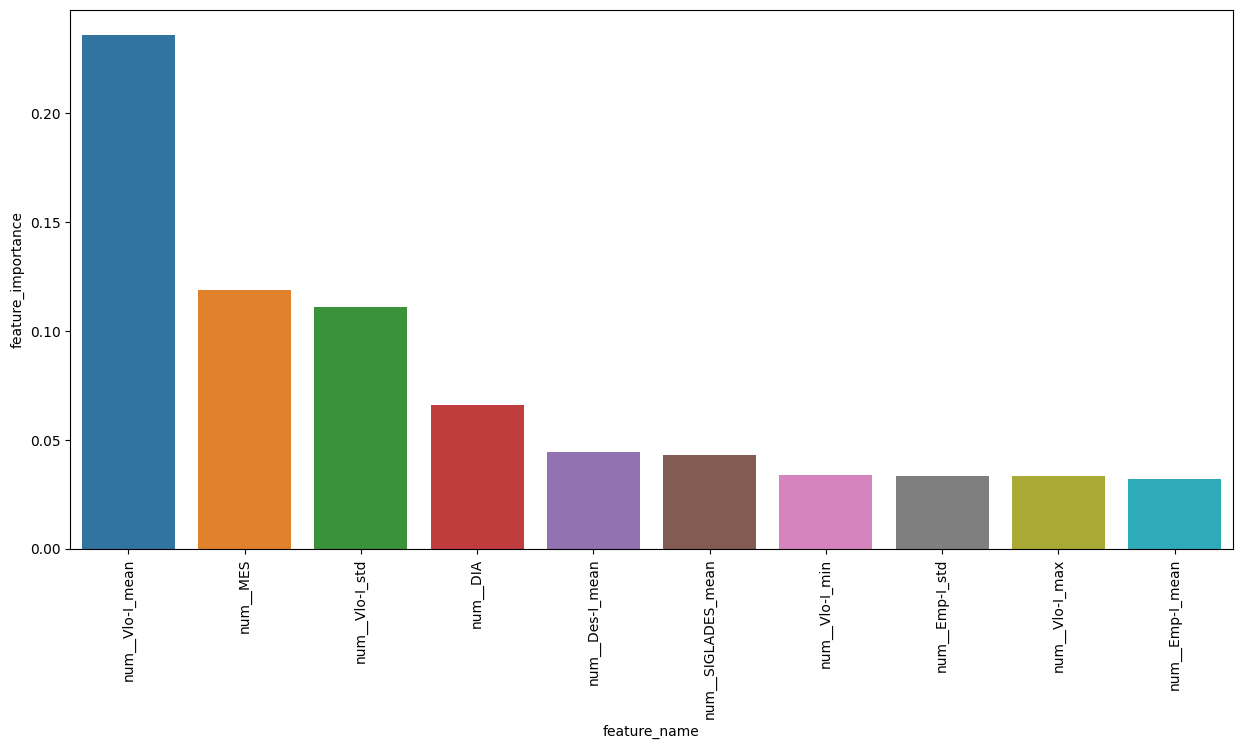

In [74]:
plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [139]:
# WandB Logs
name = "baseline:v2"
tags = ["RandomForest", "ClassWeights", "FeatureEngineering"]

# Init run
run = wandb.init(project="LatamChallenge", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, recall, auc, test_preds, test_probs, model, X_train, y_train, X_test, y_test)

# Finish Run
run.finish()

wandb: WARNING X contains 136 missing values. 
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: WARNING X_test contains 336 missing values. 
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.


AUC,0.69427
F1,0.55908
RECALL,0.39741


## Conclusiones
Vemos que se logran mejorar las métricas, ademas las variables creadas obtienen un alto puntaje en el feature importance. Ahora probaremos con un modelo más complejo

# Model: XGBoost + FE

Ahora utilizaremos un modelo más complejo para poder capturar mejores patrones en los datos. 
Además probaremos Undersample y  Oversample

In [82]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [142]:
# Features categóricas y numéricas
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and col != 'target']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object' and col != 'target']

In [143]:
num_cols

['DIA',
 'MES',
 'TAlta',
 'Vlo-I_mean',
 'Vlo-I_max',
 'Vlo-I_min',
 'Vlo-I_std',
 'Des-I_mean',
 'Des-I_max',
 'Des-I_min',
 'Des-I_std',
 'Emp-I_mean',
 'Emp-I_max',
 'Emp-I_min',
 'Emp-I_std',
 'SIGLADES_mean',
 'SIGLADES_max',
 'SIGLADES_min',
 'SIGLADES_std']

In [88]:
#cat_cols = cat_cols + ['DIA', 'MES', 'TAlta']

In [61]:
#num_cols = [col for col in num_cols if col not in ['DIA', 'MES', 'TAlta']]

In [144]:
# XGB model
weight_scale = y_train.value_counts()[0]/y_train.value_counts()[1]
xgb_class = xgb.XGBClassifier(seed = cfg.seed, scale_pos_weight=weight_scale)

# Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
  #  steps=[("preprocessor", preprocessor),('smote', smt) ,("model", xgb_class)]
    steps=[("preprocessor", preprocessor) ,("model", xgb_class)]
)

xgb_param_grid = {
    'model__max_depth': [2,  5, 10,50,100],
    'model__n_estimators': [10, 100, 500],
    'model__lambda': np.logspace(-4, 4, 10),
    'model__learning_rate':np.logspace(-3, 1, 10)
}




In [145]:
xgb_r_search = RandomizedSearchCV(pipe, xgb_param_grid, n_jobs=-1, verbose = 2, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
#xgb.DMatrix(X_train, label = y_train, feature_names = X_train.columns)
xgb_r_search.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=  17.9s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time=10.4min


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=  17.2s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time=10.5min
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=  17.5s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time=10.7min
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=  16.6s
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=  14.5s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_de

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['DIA',
                                                                                'MES',
                                                                                'TAlta',
                                                                                'Vlo-I_mean',
                                                                                'Vlo-I_max',
                                                                                'Vlo-I_min',
                                            

In [146]:
print("Best parameter (CV score=%0.3f):" % xgb_r_search.best_score_)
print(xgb_r_search.best_params_)

Best parameter (CV score=0.431):
{'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.021544346900318832, 'model__lambda': 166.81005372000558}


## Evaluación

In [88]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [147]:
test_preds = xgb_r_search.predict(X_test)
test_probs = xgb_r_search.predict_proba(X_test)
model = xgb_r_search.best_estimator_

===== Recall Score =====
Recall Test Score: 0.613
===== F1 Score =====
Test F1 Score: 0.406
===== AUC Score =====
AUC Score: 0.713
===== Confusion Matrix =====


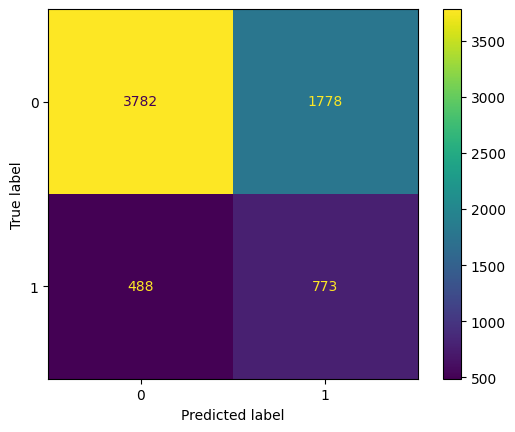

In [148]:
f1, auc, cm, recall = display_metrics(y_test, test_preds, test_probs)

In [149]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


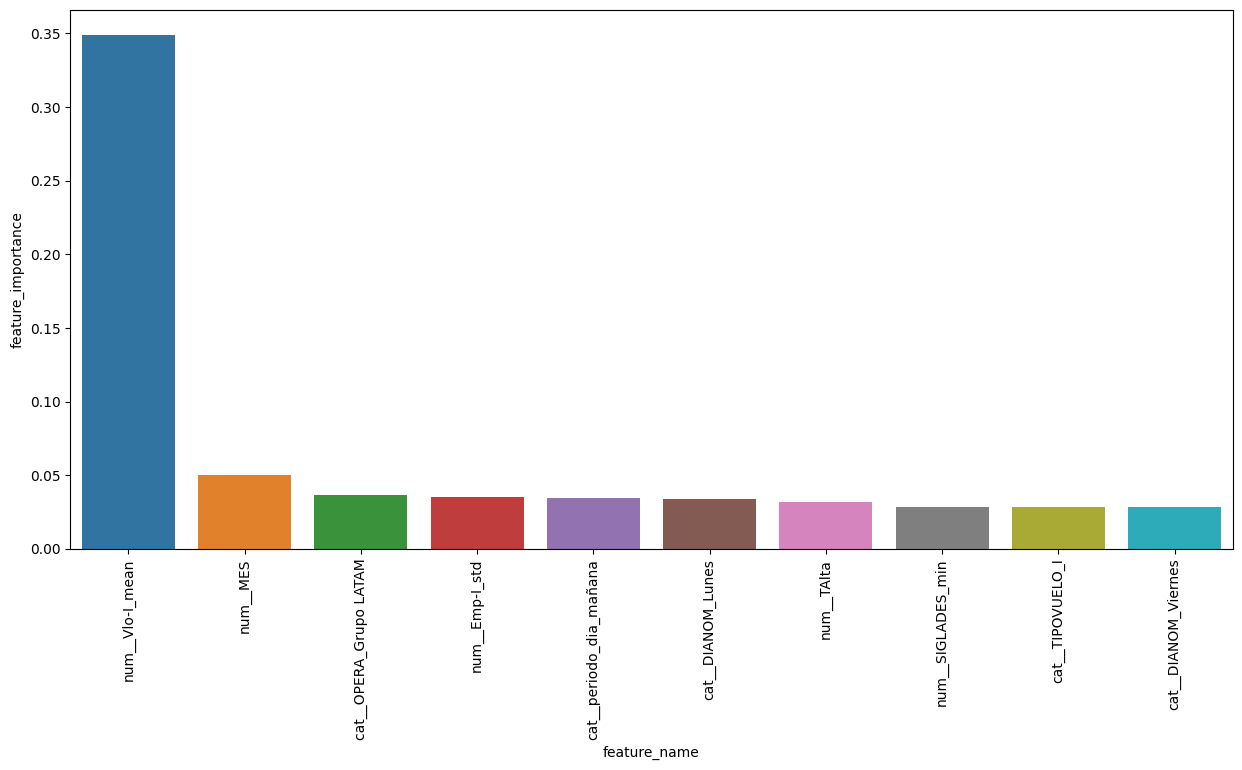

In [150]:
plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [151]:
# WandB Logs
name = "XGBoost:v1"
tags = ["ClassWeights"]

# Init run
run = wandb.init(project="LatamChallenge", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, auc, recall,  test_preds, test_probs, model, X_train, y_train, X_test, y_test)

# Finish Run
run.finish()

wandb: WARNING X contains 136 missing values. 
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: WARNING X_test contains 336 missing values. 
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.


AUC,0.61301
F1,0.71284
RECALL,0.40556


# Model: XGBoost + FE + Undersample

Ahora utilizaremos un modelo más complejo para poder capturar mejores patrones en los datos. 
Además probaremos Undersample y  Oversample

In [153]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [154]:
# UNDERSAMPLE
# Indices aleatorios a dropear
RELACION = 2 # relación 1:2 (probé otras relaciones pero no cambia mucho)
y_train.reset_index(drop=True, inplace = True)
idx_to_drop = y_train[y_train == 0].sample(y_train.value_counts()[0] - y_train.value_counts()[1]*RELACION).index
idx_to_drop

Int64Index([40689, 31895,  1090, 59545, 43899, 57246, 35573, 61208,  1795,
            29622,
            ...
            16642, 15056, 52849, 14312, 45659, 33036, 19423, 60563, 28393,
            54868],
           dtype='int64', length=27326)

In [155]:
# Undersample dataset
X_train_undersample = X_train.drop(idx_to_drop)
y_train_undersample = y_train.drop(idx_to_drop)

In [156]:
# Sanity Check
y_train_undersample.value_counts()

0    22706
1    11353
Name: target, dtype: int64

In [159]:
# Features categóricas y numéricas
cat_cols = [col for col in X_train_undersample.columns if X_train_undersample[col].dtype == 'object' and col != 'target']
num_cols = [col for col in X_train_undersample.columns if X_train_undersample[col].dtype != 'object' and col != 'target']

In [160]:
num_cols

['DIA',
 'MES',
 'TAlta',
 'Vlo-I_mean',
 'Vlo-I_max',
 'Vlo-I_min',
 'Vlo-I_std',
 'Des-I_mean',
 'Des-I_max',
 'Des-I_min',
 'Des-I_std',
 'Emp-I_mean',
 'Emp-I_max',
 'Emp-I_min',
 'Emp-I_std',
 'SIGLADES_mean',
 'SIGLADES_max',
 'SIGLADES_min',
 'SIGLADES_std']

In [88]:
#cat_cols = cat_cols + ['DIA', 'MES', 'TAlta']

In [61]:
#num_cols = [col for col in num_cols if col not in ['DIA', 'MES', 'TAlta']]

In [161]:
# XGB model
weight_scale = y_train_undersample.value_counts()[0]/y_train_undersample.value_counts()[1]
xgb_class = xgb.XGBClassifier(seed = cfg.seed, scale_pos_weight=weight_scale)

# Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
  #  steps=[("preprocessor", preprocessor),('smote', smt) ,("model", xgb_class)]
    steps=[("preprocessor", preprocessor) ,("model", xgb_class)]
)

xgb_param_grid = {
    'model__max_depth': [2,  5, 10,50,100],
    'model__n_estimators': [10, 100, 500],
    'model__lambda': np.logspace(-4, 4, 10),
    'model__learning_rate':np.logspace(-3, 1, 10)
}




In [162]:
xgb_r_search = RandomizedSearchCV(pipe, xgb_param_grid, n_jobs=-1, verbose = 2, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
#xgb.DMatrix(X_train, label = y_train, feature_names = X_train.columns)
xgb_r_search.fit(X_train_undersample , y_train_undersample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=   9.1s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time= 5.1min


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=   9.3s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time= 5.2min
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=   9.3s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time= 5.2min
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=   8.7s
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=   9.3s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_de

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['DIA',
                                                                                'MES',
                                                                                'TAlta',
                                                                                'Vlo-I_mean',
                                                                                'Vlo-I_max',
                                                                                'Vlo-I_min',
                                            

In [163]:
print("Best parameter (CV score=%0.3f):" % xgb_r_search.best_score_)
print(xgb_r_search.best_params_)

Best parameter (CV score=0.571):
{'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.021544346900318832, 'model__lambda': 166.81005372000558}


## Evaluación

In [164]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [165]:
test_preds = xgb_r_search.predict(X_test)
test_probs = xgb_r_search.predict_proba(X_test)
model = xgb_r_search.best_estimator_

===== Recall Score =====
Recall Test Score: 0.624
===== F1 Score =====
Test F1 Score: 0.409
===== AUC Score =====
AUC Score: 0.710
===== Confusion Matrix =====


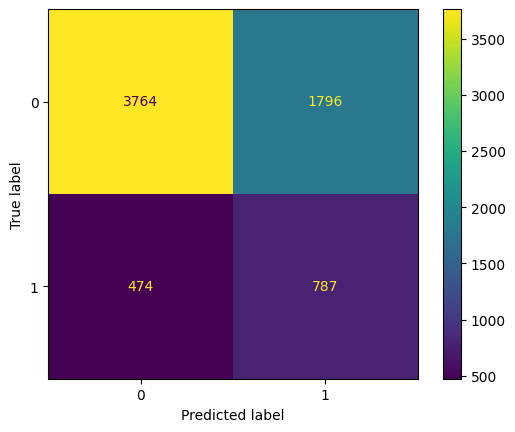

In [166]:
f1, auc, cm, recall = display_metrics(y_test, test_preds, test_probs)

In [111]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


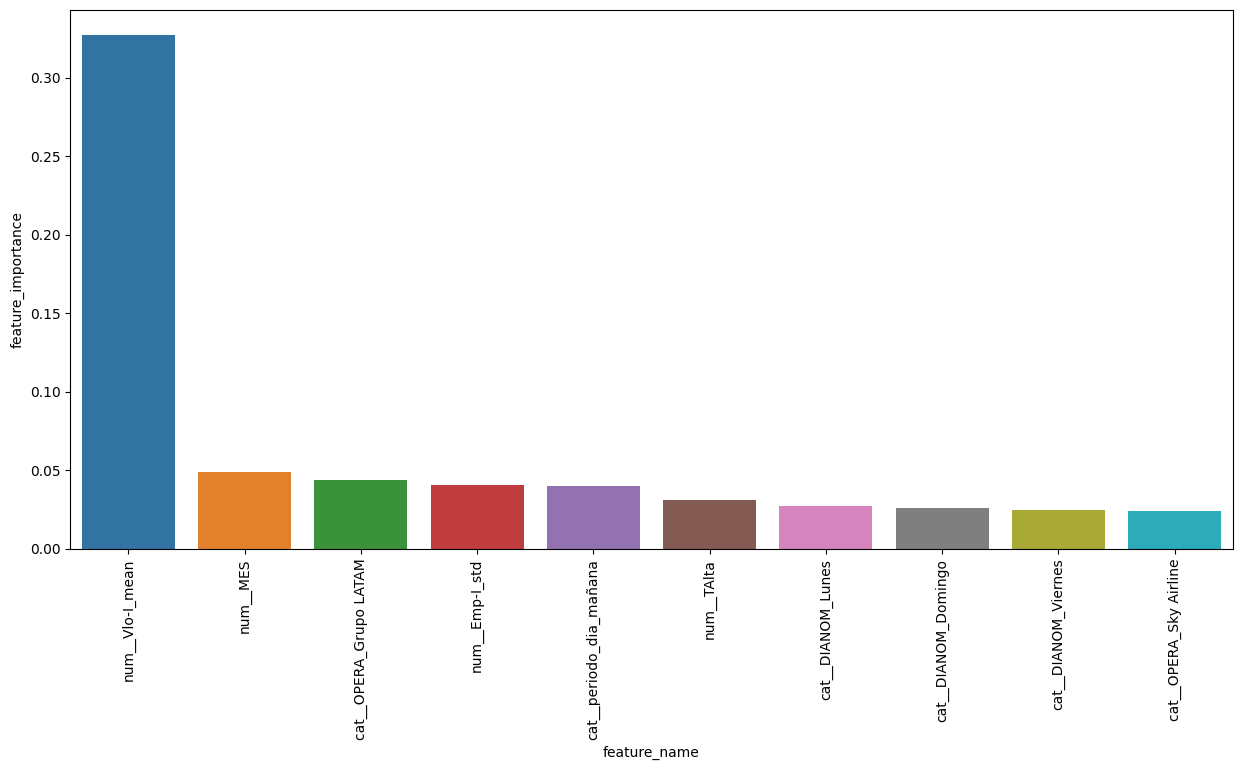

In [112]:
plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [167]:
# WandB Logs
name = "XGBoost:v2"
tags = ["ClassWeights", "Undersample2_1"]

# Init run
run = wandb.init(project="LatamChallenge", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, recall,  auc, test_preds, test_probs, model, X_train, y_train, X_test, y_test)

# Finish Run
run.finish()

wandb: WARNING X contains 136 missing values. 
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: WARNING X_test contains 336 missing values. 
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.


AUC,0.71047
F1,0.62411
RECALL,0.40947


[CV] END model__lambda=0.046415888336127774, model__learning_rate=0.007742636826811269, model__max_depth=2, model__n_estimators=10; total time=   0.7s
[CV] END model__lambda=0.046415888336127774, model__learning_rate=0.007742636826811269, model__max_depth=2, model__n_estimators=10; total time=   0.6s
[CV] END model__lambda=2.782559402207126, model__learning_rate=1.2915496650148828, model__max_depth=50, model__n_estimators=100; total time=  40.4s
[CV] END model__lambda=2.782559402207126, model__learning_rate=1.2915496650148828, model__max_depth=50, model__n_estimators=100; total time=  40.1s
[CV] END model__lambda=166.81005372000558, model__learning_rate=0.021544346900318832, model__max_depth=5, model__n_estimators=500; total time=  38.4s
[CV] END model__lambda=166.81005372000558, model__learning_rate=0.021544346900318832, model__max_depth=5, model__n_estimators=500; total time=  42.9s
[CV] END model__lambda=166.81005372000558, model__learning_rate=1.2915496650148828, model__max_depth=5

## Conclusiones
Logramos mejorar el recall pero a costa de un poco de decrecimiento en las otras métricas. Una mejor idea puede ser crear distintos modelos para cada sampleo, y luego ensamblarlos!

# Model: XGBoost + FE + Oversample (SMOTE)

Ahora utilizaremos un modelo más complejo para poder capturar mejores patrones en los datos. 
Además probaremos Undersample y  Oversample

In [115]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [116]:
# OVERSAMPLE
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = cfg.seed)

In [118]:
# Features categóricas y numéricas
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object' and col != 'target']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object' and col != 'target']

In [119]:
num_cols

['DIA',
 'MES',
 'TAlta',
 'Vlo-I_mean',
 'Vlo-I_max',
 'Vlo-I_min',
 'Vlo-I_std',
 'Des-I_mean',
 'Des-I_max',
 'Des-I_min',
 'Des-I_std',
 'Emp-I_mean',
 'Emp-I_max',
 'Emp-I_min',
 'Emp-I_std',
 'SIGLADES_mean',
 'SIGLADES_max',
 'SIGLADES_min',
 'SIGLADES_std']

In [88]:
#cat_cols = cat_cols + ['DIA', 'MES', 'TAlta']

In [61]:
#num_cols = [col for col in num_cols if col not in ['DIA', 'MES', 'TAlta']]

In [120]:
# XGB model
weight_scale = y_train.value_counts()[0]/y_train.value_counts()[1]
xgb_class = xgb.XGBClassifier(seed = cfg.seed, scale_pos_weight=weight_scale)

# Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Numeric Transformer
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

# Categorical Transformer
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Feature Processor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor),('smote', smt) ,("model", xgb_class)]
    
)

xgb_param_grid = {
    'model__max_depth': [2,  5, 10,50,100],
    'model__n_estimators': [10, 100, 500],
    'model__lambda': np.logspace(-4, 4, 10),
    'model__learning_rate':np.logspace(-3, 1, 10)
}




In [ ]:
xgb_r_search = RandomizedSearchCV(pipe, xgb_param_grid, n_jobs=-1, verbose = 2, scoring='f1', cv = cfg.Kfold, random_state=cfg.seed)
#xgb.DMatrix(X_train, label = y_train, feature_names = X_train.columns)
xgb_r_search.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__lambda=2.782559402207126, model__learning_rate=1.2915496650148828, model__max_depth=50, model__n_estimators=100; total time=  35.3s
[CV] END model__lambda=2.782559402207126, model__learning_rate=1.2915496650148828, model__max_depth=50, model__n_estimators=100; total time=  40.3s
[CV] END model__lambda=166.81005372000558, model__learning_rate=0.021544346900318832, model__max_depth=5, model__n_estimators=500; total time=  44.0s
[CV] END model__lambda=0.005994842503189409, model__learning_rate=0.021544346900318832, model__max_depth=2, model__n_estimators=10; total time=   0.6s
[CV] END model__lambda=0.005994842503189409, model__learning_rate=0.021544346900318832, model__max_depth=2, model__n_estimators=10; total time=   0.6s
[CV] END model__lambda=0.005994842503189409, model__learning_rate=0.021544346900318832, model__max_depth=2, model__n_estimators=10; total time=   0.6s
[CV] END model__lambda=0.005994842503189

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time= 5.0min
[CV] END model__lambda=166.81005372000558, model__learning_rate=0.007742636826811269, model__max_depth=100, model__n_estimators=100; total time=  35.9s
[CV] END model__lambda=2.782559402207126, model__learning_rate=3.593813663804626, model__max_depth=50, model__n_estimators=100; total time=  32.5s
[CV] END model__lambda=0.000774263682681127, model__learning_rate=0.0027825594022071257, model__max_depth=100, model__n_estimators=500; total time=19.0min
[CV] END model__lambda=2.782559402207126, model__learning_rate=1.2915496650148828, model__max_depth=50, model__n_estimators=100; total time=  36.0s
[CV] END model__lambda=166.81005372000558, model__learning_rate=0.021544346900318832, model__max_depth=5, model__n_estimators=500; total time=  44.3s
[CV] END model__lambda=166.81005372000558, model__learning_rate=0.021544346900318832, model__

In [124]:
print("Best parameter (CV score=%0.3f):" % xgb_r_search.best_score_)
print(xgb_r_search.best_params_)

Best parameter (CV score=0.421):
{'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 1.2915496650148828, 'model__lambda': 166.81005372000558}


## Evaluación

In [125]:
X_train

,DIA,MES,DIANOM,TIPOVUELO,OPERA,TAlta,periodo_dia,Vlo-I_mean,Vlo-I_max,Vlo-I_min,...,Des-I_min,Des-I_std,Emp-I_mean,Emp-I_max,Emp-I_min,Emp-I_std,SIGLADES_mean,SIGLADES_max,SIGLADES_min,SIGLADES_std
0,15,8,Martes,N,Sky Airline,0,tarde,5.845070,138.0,-12.0,...,-14.0,15.272410,8.197869,161.0,-14.0,18.568418,5.989640,161.0,-14.0,15.271107
1,19,12,Martes,N,Sky Airline,0,noche,9.918919,89.0,-10.0,...,-13.0,16.873223,8.197869,161.0,-14.0,18.568418,7.148569,159.0,-13.0,16.873223
2,10,11,Viernes,N,Sky Airline,0,tarde,9.730539,161.0,-13.0,...,-10.0,19.293633,8.197869,161.0,-14.0,18.568418,8.204511,147.0,-10.0,19.293633
3,12,10,Jueves,I,Avianca,0,tarde,16.482944,148.0,-11.0,...,-14.0,24.361335,11.210974,159.0,-14.0,24.960005,12.319207,159.0,-14.0,24.361335
4,23,2,Jueves,N,Grupo LATAM,1,tarde,7.470968,125.0,-10.0,...,-14.0,16.114970,9.130863,161.0,-14.0,17.364206,7.009470,148.0,-14.0,16.114970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61380,6,9,Miercoles,I,Grupo LATAM,0,tarde,10.122302,121.0,-10.0,...,-14.0,21.777216,9.130863,161.0,-14.0,17.364206,11.583282,159.0,-14.0,21.778395
61381,15,10,Domingo,N,Grupo LATAM,0,tarde,8.985612,127.0,-5.0,...,-14.0,19.439351,9.130863,161.0,-14.0,17.364206,8.270677,161.0,-14.0,19.214657
61382,4,11,Sabado,I,American Airlines,0,noche,2.412651,160.0,-14.0,...,-14.0,22.024187,0.341679,160.0,-14.0,16.818339,9.189636,160.0,-14.0,22.405785
61383,14,9,Jueves,I,Grupo LATAM,1,tarde,10.871951,117.0,-8.0,...,-14.0,23.196999,13.517027,159.0,-14.0,22.035668,14.391406,159.0,-14.0,23.194943


In [126]:
test_preds = xgb_r_search.predict(X_test)
test_probs = xgb_r_search.predict_proba(X_test)
model = xgb_r_search.best_estimator_

===== Recall Score =====
Recall Test Score: 0.550
===== F1 Score =====
Test F1 Score: 0.422
===== AUC Score =====
AUC Score: 0.704
===== Confusion Matrix =====


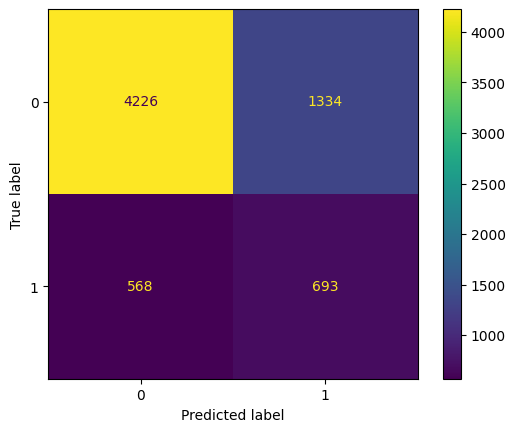

In [127]:
f1, auc, cm, recall = display_metrics(y_test, test_preds, test_probs)

In [128]:
# Feature Importance
import sklearn
# Primero debo fitear el column transformer para obtener los nombres de las variables
X_temp = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

# Feature Importance
feature_importance = model['model'].feature_importances_

# Create DataFrame
feature_importance_data = pd.DataFrame(data={'feature_name': feature_names, 'feature_importance':feature_importance})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


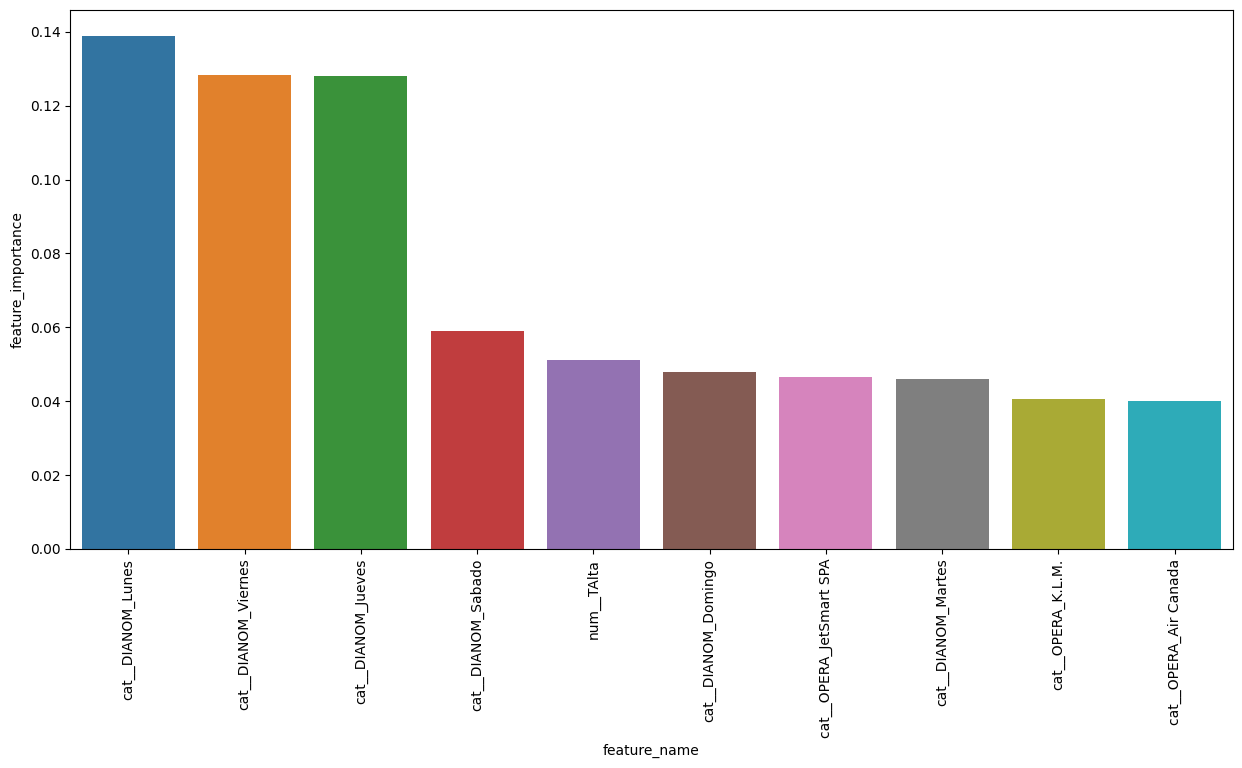

In [129]:
plt.figure(figsize = (15,7))
sns.barplot(data = feature_importance_data.sort_values(by='feature_importance', ascending = False).head(10), x='feature_name', y='feature_importance')
plt.xticks(rotation = 90);

In [130]:
# WandB Logs
name = "XGBoost:v3"
tags = ["OverSample"]

# Init run
run = wandb.init(project="LatamChallenge", entity="diegulio", name = name, tags = tags)

# logs
log_wandb(run, f1, auc, recall,  test_preds, test_probs, model, X_train, y_train, X_test, y_test)

# Finish Run
run.finish()

wandb: WARNING X contains 136 missing values. 
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: WARNING X_test contains 336 missing values. 
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.


AUC,0.54956
F1,0.70446
RECALL,0.42153


# Conclusiones Finales

El objetivo de este notebook fue demostrar un flujo común de un proyecto de Machine Learning. Si bien apunté a tener buenas métricas, no me esforcé en tener la mejor métrica posible debido al tiempo y a que siento que esta evaluación es más de analizar el problem solving. A priori Las métricas obtenidas no fueron lo suficientemente buenas para poder pasar este modelo a producción (deberiamos comparar en realidad con algunas métricas de negocio y con el baseline actual).

### Next Steps
Acá dejo algunas ideas que seguiría para poder mejorar estas métricas:

- **Data Centric**: Creo que el desafío recae en el desbalance de los datos. Debido a que existe una clara minoria de vuelos con atrasos, el modelo tiene a predecir que no hay atraso en la mayoria de ocasiones, prediciendo con poco performance las veces que hubo atraso. Para esto le daría una vuelta a los datos y utilizaria mejores técnicas para mejorar el desbalance (quizá crear una función de costos personalizadas)
- **Feature Engineering** : Las features actuales comunican poco sobre el target, eso se puede verificar viendo que en el tuneo la profunidad de los árboles era bastante baja, por lo que no se encontraron patrones extremadamente complejos. Para esto se deberian agregar más features como las mencionadas en la sección de Feature Engineering

- **Problem Re-framing**: Una idea interesante podria ser un re-frame del problema. Llevando el problema a uno de regresión, buscando predecir **dif_min** y luego utilizando el treshold de 15 min para identificar si el vuelo se atrasa o no. En mi opinión, esta idea podria ser prometedora.


### Experiment Tracking

Utilizamos la herramienta Weight and Biases para el experiment tracking, puedes visitar el siguiente  [link](https://wandb.ai/diegulio/LatamChallenge) para ver los experimentos realizados y hacer una comparación profunda entre ellos. 

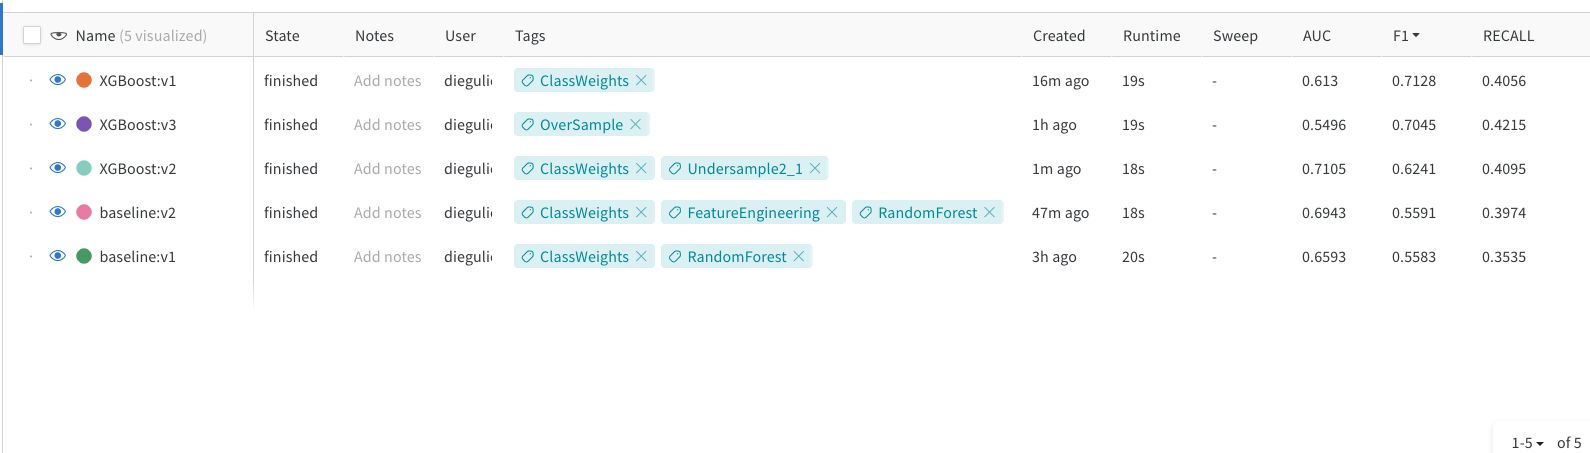


https://wandb.ai/diegulio/LatamChallenge
